<a href="https://colab.research.google.com/github/jp-ishimwe/Projects/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip3 install transformers==3.0.2 
#!pip install transformers -q
#!pip install wandb -q
!pip3 install --upgrade wandb

In [2]:
#@title Import packages { run: "auto", vertical-output: true, display-mode: "both" }
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
import numpy as np
import copy
import os

from collections import defaultdict, OrderedDict
from sklearn.base import BaseEstimator, TransformerMixin
import progressbar
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pickle
#import dill
import tarfile
import json, gzip
from typing import Optional, Union, Iterable, NamedTuple
import math
from typing import Optional, Union, Iterable, NamedTuple, Dict


#!pip install transformers==3.0.2 -qq

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import wandb


from transformers.modeling_t5 import T5Stack, T5LayerCrossAttention, T5Block, T5Attention

# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
def set_seed():
    SEED = 123
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Setting the environment**

In [4]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'Final-Model-Project.ipynb'

In [4]:
#!cp '/root/optimizers.py' '/root/Projects/' # SSH
#!cp '/home/jupyter/optimizers.py' '/home/jupyter/Projects/' # for GCP
#!cp '/content/drive/My Drive/Colab Notebooks/optimizers.py' .
#from optimizers import AdaFactor

In [5]:
!nvidia-smi
!/usr/local/cuda/bin/nvcc --version

Thu Jul 23 12:50:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    27W / 149W |     11MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
#@title To proceed should be cuda { run: "auto", vertical-output: true }
CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")
print(device)

cuda


## Getting dataset

You can find the dataset [here](http://lil.nlp.cornell.edu/newsroom/download/index.html)

**Loading dataset and unzip**

In [ ]:
fname = '/content/drive/My Drive/Colab Notebooks/newsroom-release.tar'

tar = tarfile.open(fname, "r:")
tar.extractall()
tar.close()

In [ ]:
!mv '/content/data/' '/content/drive/My Drive/Colab Notebooks'
!cp -r '/content/release/' '/content/drive/My Drive/Colab Notebooks/data'

In [4]:
#path = '/home/jupyter/' # For GCp
path = '/root/release/' # For SSH
#path = "/content/drive/My Drive/Colab Notebooks/data/release/" # For Colab

def read_data(path, name):
  data = []
  with gzip.open(path + name + ".jsonl.gz") as f: #+".jsonl.gz" with GCP
      for ln in f:
          obj = json.loads(ln)
          data.append(obj)
  return data

trainset = read_data(path, 'train') 
devset = read_data(path, 'dev')
testset = read_data(path, 'test')

In [5]:
def get_data(data):
  data_dict = {'text': [], 'summary': []}
  for article in data:
    data_dict['text'].append(article['text'])
    data_dict['summary'].append(article['summary'])
  return pd.DataFrame(data_dict)

train_data = get_data(trainset)
valid_data = get_data(devset)
test_data = get_data(testset)

In [9]:
train_data.head()

,text,summary
0,"HAMBURG, Germany, June 3  As he left the socc...",A surge in discriminatory behavior toward blac...
1,"WASHINGTON, Dec. 23 - The National Security Ag...","The volume of information harvested, without \..."
2,IF outsized executive pay has indeed become a ...,The battle between Pfizer Inc.'s investors and...
3,BY A.J. BENZA & MICHAEL LEWITTES\n\nIf Simon R...,"If Simon Rex looks a little familiar, it may n..."
4,Spinach has terrorized generations of veggie-p...,POPEYE-WORTHY PIE. PHYLLO DOUGH WRAPS SPINACH ...


In [10]:
print(f'The size of training dataset:{train_data.shape} | validation dataset: {valid_data.shape}')

The size of training dataset:(995041, 2) | validation dataset: (108837, 2)


In [6]:
contraction = {"isn't": "is not", "aren't": "are not","can't": "cannot", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you ll":"you will", "you'll've": "you will have",
                           "you're": "you are", "you re": "you are" , "you've": "you have"}

###### Checking for NA

In [12]:
train_data.isna().sum(), valid_data.isna().sum()

(text       0
 summary    0
 dtype: int64, text       0
 summary    0
 dtype: int64)

**Preprocessing**

In [7]:
class TextProccessing(BaseEstimator, TransformerMixin):
  def __init__(self, column, contraction):
    self.column = column
    self.contraction = contraction
  def fit(self, x, y=None):
    return self
  @staticmethod
  def preprocessing(line):
    date_pattern = r'(0?[1-9]/|1[0-2]/)(0?[1-9]/|[1-2][0-9]/|3[0-1]/)[0-9]{4}'
    line = line.split("\n")
    clean_line = []
    for l in line:
        if re.match(date_pattern, l) is not None:
            pass
        else:
            clean_line.append(l)
    line = "\n".join(clean_line)

    line = re.sub(r"http\S+", " ",line)
    line = re.sub(r"www\S+", " ",line)
    line = line.replace('—', ' ')
    line = line.replace('-', ' ')
    line = line.replace('&', 'and')
    line = line.replace('[...]', '')
    line = line.replace('...', '.')
    line = line.replace('…', ' ')
    line = re.sub(re.compile('<.*?>'), '', line)
    line = re.sub(re.compile('@\S+'), r'', line)
    line = re.sub(r'#\S+ ', r'', line)
    line = line.replace("â", "'") 
    line = line.replace('--', ' ')
    line = re.sub(r'[^\sa-zA-Z0-9.,!?]',' ',line)
    line = line.strip()
    line = line.replace("\xa0", "")
    line = line.replace("click to share on twitter", "")

    line = re.sub(r'[ \t]{2,}',' ', line)
    return line

  def transform(self, X):
    return X[self.column].replace(self.contraction).fillna('').apply(lambda x: self.preprocessing(x)) 

In [8]:
class Processor:

  def __init__(self, data, 
               contraction,
               max_length = None):
    
    self.max_length = max_length
    self.data = data
    self.contraction = contraction

    
  def cleaning(self, data):
    if not isinstance(data, pd.DataFrame):
      raise TypeError('Only Dataframes are allowed, but got data={}'.format(data))
    else:
      print('Please wait, we are cleaning...')
      titles = ['text', 'summary']
      data_dict = {}

      for title in titles:
        proc = TextProccessing(title, self.contraction)
        res = proc.fit_transform(data)
        data_dict[title] = res

      ss = pd.DataFrame(data_dict)
      
      return ss

  @staticmethod
  def split(data):
    return len(data.split())

  def get_max_tokens(self, dataframe):

    dataframe['article_len'] = dataframe['text'].apply(self.split)
    dataframe['summary_len'] = dataframe['summary'].apply(self.split)
    
    max_len = {'max_article_tokens': max(dataframe['article_len']), 
                'min_article_tokens': min(dataframe['article_len']),
                'max_summary_tokens': max(dataframe['summary_len']),
                'min_summary_tokens': min(dataframe['summary_len'])}
    return max_len, dataframe

  def cleaned_data(self):
    dataframe = self.cleaning(self.data)
    
    if self.max_length is None:
      min_len, dataframe = self.get_max_tokens(dataframe)
    else:
      min_len = self.max_length

    min_length = min_len['min_article_tokens']
    idx_list = []
    for idx, paragraph in tqdm(enumerate(dataframe['text'])):
        pragraph = len(paragraph.split())
        if pragraph < min_length:
          idx_list.append(idx)
    final_data = dataframe.drop(idx_list)
    final_data = final_data.reset_index(drop=True)
    
    if self.max_length is not None:
        min_len, final_data = self.get_max_tokens(final_data)

    print('Done!')
    
    return final_data, min_len

In [9]:
maxlen = {'max_article_tokens': 512,
          'max_summary_tokens': 300,
          'min_article_tokens': 100,
          'min_summary_tokens': 0}

In [10]:
textproc = Processor(train_data, contraction, maxlen)
train_processed, doc_lengths = textproc.cleaned_data()

Please wait, we are cleaning...


995041it [00:31, 31844.18it/s]


Done!


In [13]:
textproc = Processor(valid_data, contraction, maxlen)
valid_processed, valid_doc_lengths = textproc.cleaned_data()

Please wait, we are cleaning...


108837it [00:03, 32442.50it/s]


Done!


**Saving project**

In [ ]:
train_processed.to_pickle("./train_processed.pkl")

In [14]:
valid_processed.to_pickle("./valid_processed.pkl")

In [11]:
train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951381 entries, 0 to 951380
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         951381 non-null  object
 1   summary      951381 non-null  object
 2   article_len  951381 non-null  int64 
 3   summary_len  951381 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 29.0+ MB


Only one article droped that was having zeros length. However we still have some article with no summaries. Therefore we can get rid off them.

**Loading pre-processed data**

In [6]:
train_processed = pd.read_pickle("./train_processed.pkl")
valid_processed = pd.read_pickle("./valid_processed.pkl")

In [7]:
indices = np.where(train_processed['summary_len'] < 10)
train_processed_data = train_processed.drop(indices[0])
train_processed_data = train_processed_data.reset_index(drop=True)
#train_processed.iloc[indices[0]]

In [10]:
#train_data.iloc[954753]['summary'] # '<ul>\n\t<li><b>£', 'Ø¨Ø§ Ø§Û\x8cÙ\x86 Ø§Ø\xadØ³Ø§Ø³ Ø¯Ø±Ù\x85Ø§Ù\x86Ø¯Ú¯Û\x8cØ\x8c Ø¨Ù\x87 Ù\x86Ø¸Ø±Øª Ù\x85Û\x8câ\x80\x8fØ±Ø³Ø¯ Ú©Ù\x87 ØªØ\xadØ±Û\x8cÙ\x85â\x80\x8fÙ\x87Ø§ Ø¯Ø§Ø±Ù\x86Ø¯ Ú©Ø§Ø± Ù\x85Û\x8câ\x80\x8fÚ©Ù\x86Ù\x86Ø¯'

In [11]:
train_processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882676 entries, 0 to 882675
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         882676 non-null  object
 1   summary      882676 non-null  object
 2   article_len  882676 non-null  int64 
 3   summary_len  882676 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 26.9+ MB


In [12]:
train_processed_data['summary_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000     24.0
0.7500     31.0
0.9000     44.0
0.9500     58.0
0.9900    141.0
0.9990    343.0
0.9999    663.0
Name: summary_len, dtype: float64

In [34]:
train_processed_data['article_len'].quantile([0.1,0.25,0.4,0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.1000      192.000
0.2500      322.000
0.4000      465.000
0.5000      574.000
0.7500      890.000
0.9000     1237.000
0.9500     1575.000
0.9900     3206.250
0.9990     8660.600
0.9999    23091.975
Name: article_len, dtype: float64

In [35]:
valid_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104147 entries, 0 to 104146
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         104147 non-null  object
 1   summary      104147 non-null  object
 2   article_len  104147 non-null  int64 
 3   summary_len  104147 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.2+ MB


In [8]:
inds = np.where(valid_processed['summary_len'] < 10)
valid_processed_data = valid_processed.drop(inds[0])
valid_processed_data = valid_processed_data.reset_index(drop=True)

In [14]:
valid_processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96581 entries, 0 to 96580
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         96581 non-null  object
 1   summary      96581 non-null  object
 2   article_len  96581 non-null  int64 
 3   summary_len  96581 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


In [6]:
valid_processed_data['article_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000      571.000
0.7500      885.000
0.9000     1228.000
0.9500     1568.000
0.9900     3119.600
0.9990     8641.460
0.9999    22122.936
Name: article_len, dtype: float64

In [7]:
valid_processed_data['summary_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000     24.000
0.7500     31.000
0.9000     45.000
0.9500     60.000
0.9900    146.000
0.9990    364.000
0.9999    724.234
Name: summary_len, dtype: float64

In [9]:
art = 700 #int(train_processed_data['article_len'].quantile(0.9900))
sum_ = 250# int(train_processed_data['summary_len'].quantile(0.9900))

print(f'art len:{art}, sum len:{sum_}')

art len:700, sum len:250


In [10]:
artV = 700 #int(valid_processed_data['article_len'].quantile(0.9900))
sumV = 250# int(valid_processed_data['summary_len'].quantile(0.9900))

print(f'art len:{artV}, sum len:{sumV}')

art len:700, sum len:250


#### Creating Custom Dataset

In [14]:
class CustomDataReader(Dataset):
  """
  Loading data to be used in pytorch pre-trained models
  
  """
  def __init__(self, dataframe, T5tokenizer, max_article_tokens=None,max_summary_tokens=None ):
    self.tokenizer = T5tokenizer
    self.dataframe = dataframe
    self.eos = ' </s>'  #tokenizer.eos_token
    self.sos = '<pad> ' #tokenizer.pad_token
    self.source_len = max_article_tokens
    self.target_len = max_summary_tokens
  
  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, idx):
    articles = "summarize: " + self.dataframe.text[idx] + self.eos
    articles = ' '.join(articles.split())

    summary = self.sos + self.dataframe.summary[idx] + self.eos
    summary = ' '.join(summary.split())

    source_tokenized = self.tokenizer.batch_encode_plus([articles], max_length= self.source_len, pad_to_max_length=True, truncation=True,return_tensors='pt')
    target_tokenized = self.tokenizer.batch_encode_plus([summary], max_length= self.target_len, pad_to_max_length=True, truncation=True,return_tensors='pt')

    source_ids = source_tokenized['input_ids'].squeeze(0)
    source_mask = source_tokenized['attention_mask'].squeeze(0)

    summary_ids = target_tokenized['input_ids'].squeeze(0)
    summary_mask = target_tokenized['attention_mask'].squeeze(0)

    return source_ids, source_mask, summary_ids, summary_mask


In [15]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

#### Training Loop

In [16]:
def training(model, dataset_loader, optimizer,log_interval,regularizer, eps_sched=None, batchs=None,epoch=0):

    model.train()
    avg_loss = 0
    nItem = 0


    print(f'\nStart training for epoch: {epoch}')
    
    losses = AverageMeter()
    tqdok = tqdm(dataset_loader, total=len(dataset_loader))
 
    for idx, data_train in enumerate(tqdok):

        input_ids, source_mask, summary_ids, summary_mask = data_train

        input_ids = input_ids.to(device, dtype = torch.long)
        source_mask = source_mask.to(device, dtype = torch.float)
        summary_ids = summary_ids.to(device, dtype = torch.long)

        target_labels = summary_ids[:, :-1].contiguous()
        langm_labels = summary_ids[:, 1:].clone().detach()
        langm_labels[summary_ids[:, 1:] == tokenizer.pad_token_id] = -100

        optimizer.zero_grad()

        output = model(input_ids=input_ids, attention_mask = source_mask, decoder_input_ids=target_labels, labels=langm_labels, lambd=regularizer)

        loss = output[0]

        loss.backward()
        optimizer.step()

        bs = input_ids.size(0)
        nItem += bs
        
        # Before next loop: anneal optimizer variables 
        
        if eps_sched is not None and  batchs is not None:
            itr = epoch*(len(dataset_loader.dataset)//batchs) + idx
            optimizer.param_groups[0]['eps'] = eps_sched[itr]

        avg_loss += loss.item() * bs

        if idx%log_interval == 0:
            wandb.log({"Training Loss": loss.item()})
#         if idx % 5000 == 0:
#             print(f'[{idx * len(input_ids)}/{len(dataset_loader.dataset)} ({100. * idx / len(dataset_loader):.0f})%] \t Training loss: {loss:.3f}')
   

        losses.update(loss.item(), bs)
        tqdok.set_postfix(loss=losses.avg)
        
    avg_loss /= nItem
  
    return avg_loss, output


In [17]:
def validation(model, dataset_loader, regularizer):
    model.eval()

    eval_loss = 0
    nItem = 0

    losses = AverageMeter()
    tqdok = tqdm(dataset_loader, total=len(dataset_loader))

    with torch.no_grad():
        for idx, data_val in enumerate(tqdok):
            input_ids, source_mask, summary_ids, summary_mask = data_val

            input_ids = input_ids.to(device, dtype = torch.long)
            source_mask = source_mask.to(device, dtype = torch.float)
            summary_ids = summary_ids.to(device, dtype = torch.long)

            target_labels = summary_ids[:, :-1].contiguous()
            langm_labels = summary_ids[:, 1:].clone().detach()
            langm_labels[summary_ids[:, 1:] == tokenizer.pad_token_id] = -100

            output = model(input_ids=input_ids, attention_mask = source_mask, decoder_input_ids=target_labels, labels=langm_labels, lambd=regularizer)

            loss = output[0]

            bs = input_ids.size(0)
            nItem += bs

            eval_loss += loss.item()

            losses.update(loss.item(), bs)
            tqdok.set_postfix(loss=losses.avg)

    eval_loss /= nItem

    return eval_loss

In [18]:
def saving(PATH, epoch, optm, model, LEARNING_RATE):
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optm.state_dict(),
            'learning_rate': LEARNING_RATE
            }, PATH)

#### The model evaluation

The perplexity:

\begin{align}
\large \text{ppl}(p, D) &\large = 2^{-\frac{1}{N_{total}}\log_2 p(D)}
\end{align}

where $D=\{(w_1,\ldots,w_{N_i})_i\}_{i=1}^M$ is a dataset of $M$ sequences with total length $N_{\text{total}}=\sum_{i}N_i$.


#### Computing perplexity

Our model's loss is the (negative) log probability of every token in the output sequence, which can be used to compute perplexity.

We define perplexity using the **base 2** logarithm.

In [19]:
def get_perplexity(epoc_loss):
  rs = epoc_loss/np.log(2)
  pp = 2**rs
  return pp

In [20]:
#@title #### Loading T5 model and its Tokenizer { run: "auto" }

LEARNING_RATE = 3.55e-4
MODEL_NAME = 't5-base' # or T5-Large:770 params, T5-3B, T5-Base: 220 Params, T5-11B
t5model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

In [24]:
class GatedFilterLayer(nn.Module):
  r"""
  Receives the keys from the encoder output.

  Returns:
    Output the values between [0,1]
   """

  def __init__(self, config ):
    super(GatedFilterLayer, self).__init__()

    self.d_kv = config.d_kv
    self.n_heads = config.num_heads
    self.projector = nn.Linear(self.d_kv, 1,bias=False)

  def forward(self, last_hidden_encoder):
    
    bs = last_hidden_encoder.shape[0]
    keys = last_hidden_encoder.view(bs, -1, self.n_heads, self.d_kv).transpose(1, 2)
    proj = self.projector(keys)
    gate = torch.sigmoid(proj)

    return gate 

In [25]:
class EncoderStack(T5Stack):

  def __init__(self,config, embed_tokens=None):
    super().__init__(config)

    self.embed_tokens = embed_tokens 
    self.is_decoder = config.is_decoder
    self.config = config
    self.gatefilter = GatedFilterLayer(config)

  def forward(self, 
              input_ids=None,
              attention_mask=None,
              encoder_hidden_states=None,
              encoder_attention_mask=None,
              inputs_embeds=None,
              head_mask=None,
              past_key_value_states=None,
              use_cache=False,
              output_attentions=None,
              output_hidden_states=None,
          ):
    
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
            input_ids = input_ids.view(-1, input_shape[-1])
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            if self.is_decoder:
                raise ValueError("You have to specify either decoder_input_ids or decoder_inputs_embeds")
            else:
                raise ValueError("You have to specify either input_ids or inputs_embeds")

        if inputs_embeds is None:
            assert self.embed_tokens is not None, "You have to intialize the model with valid token embeddings"
            inputs_embeds = self.embed_tokens(input_ids)

        batch_size, seq_length = input_shape

        if past_key_value_states is not None:
            assert seq_length == 1, "Input shape is {}, but should be {} when using past_key_value_sates".format(
                input_shape, (batch_size, 1)
            )
            # required mask seq length can be calculated via length of past
            # key value states and seq_length = 1 for the last token
            mask_seq_length = past_key_value_states[0][0].shape[2] + seq_length
        else:
            mask_seq_length = seq_length

        if attention_mask is None:
            attention_mask = torch.ones(batch_size, mask_seq_length).to(inputs_embeds.device)
        if self.is_decoder and encoder_attention_mask is None and encoder_hidden_states is not None:
            encoder_seq_length = encoder_hidden_states.shape[1]
            encoder_attention_mask = torch.ones(
                batch_size, encoder_seq_length, device=inputs_embeds.device, dtype=torch.long
            )

        # initialize past_key_value_states with `None` if past does not exist
        if past_key_value_states is None:
            past_key_value_states = [None] * len(self.block)

        # ourselves in which case we just need to make it broadcastable to all heads.
        extended_attention_mask = self.get_extended_attention_mask(attention_mask, input_shape, inputs_embeds.device)

        if self.is_decoder and encoder_attention_mask is not None:
            encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_extended_attention_mask = None

        # Prepare head mask if needed
        head_mask = self.get_head_mask(head_mask, self.config.num_layers)
        present_key_value_states = ()
        all_hidden_states = ()
        all_attentions = ()
        position_bias = None
        encoder_decoder_position_bias = None

        hidden_states = self.dropout(inputs_embeds)

        for i, (layer_module, past_key_value_state) in enumerate(zip(self.block, past_key_value_states)):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_outputs = layer_module(
                hidden_states,
                attention_mask=extended_attention_mask,
                position_bias=position_bias,
                encoder_hidden_states=encoder_hidden_states,
                encoder_attention_mask=encoder_extended_attention_mask,
                encoder_decoder_position_bias=encoder_decoder_position_bias,
                head_mask=head_mask[i],
                past_key_value_state=past_key_value_state,
                use_cache=use_cache,
                output_attentions=output_attentions,
            )
            # layer_outputs is a tuple with:
            # hidden-states, key-value-states, (self-attention weights), (self-attention position bias), (cross-attention weights), (cross-attention position bias)
            hidden_states, present_key_value_state = layer_outputs[:2]

            if i == 0:
                # We share the position biases between the layers - the first layer store them
                # layer_outputs = hidden-states, key-value-states (self-attention weights), (self-attention position bias), (cross-attention weights), (cross-attention position bias)
                position_bias = layer_outputs[3 if output_attentions else 2]
                if self.is_decoder and encoder_hidden_states is not None:
                    encoder_decoder_position_bias = layer_outputs[5 if output_attentions else 3]
            # append next layer key value states
            present_key_value_states = present_key_value_states + (present_key_value_state,)

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[2],)  # We keep only self-attention weights for now

        hidden_states = self.final_layer_norm(hidden_states)
        hidden_states = self.dropout(hidden_states)
        
        # Add last layer
        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        outputs = (hidden_states,)
        if use_cache is True:
            assert self.is_decoder, "`use_cache` can only be set to `True` if {} is used as a decoder".format(self)
            outputs = outputs + (present_key_value_states,)
        if output_hidden_states:
            outputs = outputs + (all_hidden_states,)
        if output_attentions:
            outputs = outputs + (all_attentions,)

        # Defining gates

        last_hidden_state = outputs[0]
        gates = self.gatefilter(last_hidden_state)
        outputs = outputs + (gates,)

        return outputs  # last-layer hidden state, (presents,) (all hidden states), (all attentions), (gates,)

In [26]:
def softmax(scores,g):

  scores_max = torch.max(scores,dim=-1)[0].unsqueeze(-1)
  scores = scores - scores_max
  A = torch.exp(scores) # (bs, n_heads, qlen, klen)
  g= g.permute(0,1,3,2) # (bs, n_heads,1, klen)
  A_g = g * A
  sum_norm = torch.sum(A_g,axis=-1).unsqueeze(-1)
  weights = A_g/sum_norm
  return weights

In [27]:
class T5GatedAtention(T5Attention):
  r"""
  The source code is from huggingface. For more details, check their github 
  @https://github.com/huggingface/transformers/blob/master/src/transformers/modeling_t5.py#L204
  
  Retuns:
    Context, attentions weights on the keys for the provided queries  
  """

  def __init__(self, config, has_relative_attention_bias = False): 
    super(T5GatedAtention, self).__init__(config)

    self.has_relative_attention_bias = has_relative_attention_bias 
    self.relative_attention_num_buckets = config.relative_attention_num_buckets
    self.config = config
    self.config.is_decoder = True
    self.n_heads = config.num_heads

    if self.has_relative_attention_bias:
      self.relative_attention_bias = nn.Embedding(self.relative_attention_num_buckets, self.n_heads)

  def extract_for_test(self, hidden_states, gates):
    
    # thresholding gates values
    gate_indices = gates > self.config.threshold 
    # Creating gate mask
    gate_mask = gate_indices * 1
    # getting extracted valid values of gates and last hidden states
    extracted_gates = gate_mask * gates
    extracted_hidden_state = hidden_states * gate_mask

    return extracted_hidden_state, extracted_gates

  def forward(
        self,
        input,
        gates,
        mask=None,
        kv=None,
        position_bias=None,
        past_key_value_state=None,
        head_mask=None,
        query_length=None,
        use_cache=True,
        output_attentions=False,
    ):
        """
        Self-attention (if kv is None) or attention over source sentence (provided by kv).
        """
        # Input is (bs, qlen, dim)
        # Mask is (bs, klen) (non-causal) or (bs, klen, klen)
        # past_key_value_state[0] is (bs, n_heads, q_len - 1, dim_per_head)
        bs, qlen, dim = input.size()

        if past_key_value_state is not None:
            assert self.config.is_decoder is True, "Encoder cannot cache past key value states"
            assert (
                len(past_key_value_state) == 2
            ), "past_key_value_state should have 2 past states: keys and values. Got {} past states".format(
                len(past_key_value_state)
            )
            real_qlen = qlen + past_key_value_state[0].shape[2] if query_length is None else query_length
        else:
            real_qlen = qlen

        if kv is None:
            klen = real_qlen
        else:
            klen = kv.size(1)

        def shape(x):
            """  projection """
            return x.view(bs, -1, self.n_heads, self.d_kv).transpose(1, 2)

        def unshape(x):
            """  compute context """
            return x.transpose(1, 2).contiguous().view(bs, -1, self.inner_dim)

        q = shape(self.q(input))  # (bs, n_heads, qlen, dim_per_head)
        

        if kv is None:
            k = shape(self.k(input))  # (bs, n_heads, qlen, dim_per_head)
            v = shape(self.v(input))  # (bs, n_heads, qlen, dim_per_head)

        elif past_key_value_state is None:
            k = v = kv
            k = shape(self.k(k))  # (bs, n_heads, qlen, dim_per_head)
            v = shape(self.v(v))  # (bs, n_heads, qlen, dim_per_head)

        if past_key_value_state is not None:
            if kv is None:
                k_, v_ = past_key_value_state
                k = torch.cat([k_, k], dim=2)  # (bs, n_heads, klen, dim_per_head)
                v = torch.cat([v_, v], dim=2)  # (bs, n_heads, klen, dim_per_head)
            else:
                k, v = past_key_value_state

        if self.config.is_decoder and use_cache is True:
            present_key_value_state = ((k, v),)
        else:
            present_key_value_state = (None,)

        # For evaluation remove irrelevant if we want to
        if not self.training:
            k, gates = self.extract_for_test(k, gates)
            v, _ = self.extract_for_test(v, gates)

        scores = torch.einsum("bnqd,bnkd->bnqk", q, k)  # (bs, n_heads, qlen, klen)

        if position_bias is None:
            if not self.has_relative_attention_bias:
                raise ValueError("No position_bias provided and no weights to compute position_bias")
            position_bias = self.compute_bias(real_qlen, klen)

            # if key and values are already calculated
            # we want only the last query position bias
            if past_key_value_state is not None:
                position_bias = position_bias[:, :, -1:, :]

            if mask is not None:
                position_bias = position_bias + mask  # (bs, n_heads, qlen, klen)

        scores += position_bias

        #if gate_filter_output is not None:
        bsk, n_headsk, klenk, _ = k.size()
        bsg, n_headsg, kleng, _ = gates.size()

        error_message = "Shapes missmatch. There should be gate of shape {}. Got {}".format(k.shape,gates.shape)
        assert (bsg, n_headsg, kleng) == (bsk, n_headsk, klenk), error_message


        weights = softmax(scores.float(), g=gates).type_as(scores)  # (bs, n_heads, qlen, klen)
        #weights = F.softmax(scores.float()).type_as(scores)  # (bs, n_heads, qlen, klen)

        weights = F.dropout(weights, p=self.dropout, training=self.training)  # (bs, n_heads, qlen, klen)

        # Mask heads if we want to
        if head_mask is not None:
            weights = weights * head_mask

        context = torch.matmul(weights, v)  # (bs, n_heads, qlen, dim_per_head)
        context = unshape(context)  # (bs, qlen, dim)

        context = self.o(context)

        outputs = (context,) + present_key_value_state

        if output_attentions: 
            outputs = outputs + (weights,)
        if self.has_relative_attention_bias:
            outputs = outputs + (position_bias,)
        return outputs


In [28]:
class T5LayerGatedCrossAttention(T5LayerCrossAttention):

  def __init__(self, config, has_relative_attention_bias=False):
        super().__init__(config)

        self.EncDecAttention = T5GatedAtention(config, has_relative_attention_bias)

  def forward(
      self,
      hidden_states,
      gates,
      kv,
      attention_mask=None,
      position_bias=None,
      head_mask=None,
      past_key_value_state=None,
      use_cache=True,
      query_length=None,
      output_attentions=False,
  ):
      norm_x = self.layer_norm(hidden_states)
      attention_output = self.EncDecAttention(
          norm_x,
          gates = gates,
          mask=attention_mask,
          kv=kv,
          position_bias=position_bias,
          head_mask=head_mask,
          past_key_value_state=past_key_value_state,
          use_cache=use_cache,
          query_length=query_length,
          output_attentions=output_attentions,
      )
      y = attention_output[0]
      layer_output = hidden_states + self.dropout(y)
      outputs = (layer_output,) + attention_output[1:]  # add attentions if we output them
      return outputs


In [29]:
class GatedT5Block(T5Block):

  def __init__(self,config,DecodBlock):
    super(GatedT5Block, self).__init__(config)

    self.config = config
    self.layer = DecodBlock.layer

  def forward(
      self,
      hidden_states,
      gates,
      attention_mask=None,
      position_bias=None,
      encoder_hidden_states=None,
      encoder_attention_mask=None,
      encoder_decoder_position_bias=None,
      head_mask=None,
      past_key_value_state=None,
      use_cache=True,
      output_attentions=False,
  ):

      if past_key_value_state is not None:
          assert self.config.is_decoder, "Only decoder can use `past_key_value_states`"
          expected_num_past_key_value_states = 2 if encoder_hidden_states is None else 4

          error_message = "There should be {} past states. 2 (past / key) for self attention.{} Got {} past key / value states".format(
              expected_num_past_key_value_states,
              "2 (past / key) for cross attention" if expected_num_past_key_value_states == 4 else "",
              len(past_key_value_state),
          )
          assert len(past_key_value_state) == expected_num_past_key_value_states, error_message

          self_attn_past_key_value_state = past_key_value_state[:2]
          cross_attn_past_key_value_state = past_key_value_state[2:]
      else:
          self_attn_past_key_value_state, cross_attn_past_key_value_state = None, None

      self_attention_outputs = self.layer[0](
          hidden_states,
          attention_mask=attention_mask,
          position_bias=position_bias,
          head_mask=head_mask,
          past_key_value_state=self_attn_past_key_value_state,
          use_cache=use_cache,
          output_attentions=output_attentions,
      )
      hidden_states, present_key_value_state = self_attention_outputs[:2]
      attention_outputs = self_attention_outputs[2:]  # Keep self-attention outputs and relative position weights

      if self.config.is_decoder and encoder_hidden_states is not None:
          # the actual query length is unknown for cross attention
          # if using past key value states. Need to inject it here
          if present_key_value_state is not None:
              query_length = present_key_value_state[0].shape[2]
          else:
              query_length = None

          cross_attention_outputs = self.layer[1](
              hidden_states,
              gates=gates,
              kv=encoder_hidden_states,
              attention_mask=encoder_attention_mask,
              position_bias=encoder_decoder_position_bias,
              head_mask=head_mask,
              past_key_value_state=cross_attn_past_key_value_state,
              query_length=query_length,
              use_cache=use_cache,
              output_attentions=output_attentions,
          )
          hidden_states = cross_attention_outputs[0]
          # Combine self attn and cross attn key value states
          
          # print('present_key_value_state',present_key_value_state)
          # print('cross_attention_outputs[1]', cross_attention_outputs[1])
          
          if present_key_value_state is not None:
              present_key_value_state = present_key_value_state + cross_attention_outputs[1]

          # Keep cross-attention outputs and relative position weights
          attention_outputs = attention_outputs + cross_attention_outputs[2:]

      # Apply Feed Forward layer
      hidden_states = self.layer[-1](hidden_states)
      outputs = (hidden_states,)

      # Add attentions if we output them
      outputs = outputs + (present_key_value_state,) + attention_outputs
      return outputs

In [30]:
class GatedT5Stack(T5Stack):
    def __init__(self, config, t5model, embed_tokens=None):
        super(GatedT5Stack, self).__init__(config)

        self.embed_tokens = embed_tokens
        self.block = nn.ModuleList([GatedT5Block(config, t5model.decoder.block[i]) for i in range(config.num_layers)])
        self.config = config

    def forward(
        self,
        gates,
        input_ids=None,
        attention_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        inputs_embeds=None,
        head_mask=None,
        past_key_value_states=None,
        use_cache=True,
        output_attentions=None,
        output_hidden_states=None,
    ):

        use_cache = use_cache if use_cache is not None else self.config.use_cache
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
            input_ids = input_ids.view(-1, input_shape[-1])
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            if self.config.is_decoder:
                raise ValueError("You have to specify either decoder_input_ids or decoder_inputs_embeds")
            else:
                raise ValueError("You have to specify either input_ids or inputs_embeds")

        if inputs_embeds is None:
            assert self.embed_tokens is not None, "You have to intialize the model with valid token embeddings"
            inputs_embeds = self.embed_tokens(input_ids)

        batch_size, seq_length = input_shape

        if past_key_value_states is not None:
            assert seq_length == 1, "Input shape is {}, but should be {} when using past_key_value_sates".format(
                input_shape, (batch_size, 1)
            )
            # required mask seq length can be calculated via length of past
            # key value states and seq_length = 1 for the last token
            mask_seq_length = past_key_value_states[0][0].shape[2] + seq_length
        else:
            mask_seq_length = seq_length

        if attention_mask is None:
            attention_mask = torch.ones(batch_size, mask_seq_length).to(inputs_embeds.device)
        if self.config.is_decoder and encoder_attention_mask is None and encoder_hidden_states is not None:
            encoder_seq_length = encoder_hidden_states.shape[1]
            encoder_attention_mask = torch.ones(
                batch_size, encoder_seq_length, device=inputs_embeds.device, dtype=torch.long
            )

        # initialize past_key_value_states with `None` if past does not exist
        if past_key_value_states is None:
            past_key_value_states = [None] * len(self.block)

        # ourselves in which case we just need to make it broadcastable to all heads.
        extended_attention_mask = self.get_extended_attention_mask(attention_mask, input_shape, inputs_embeds.device)

        if self.config.is_decoder and encoder_attention_mask is not None:
            encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_extended_attention_mask = None

        # Prepare head mask if needed
        head_mask = self.get_head_mask(head_mask, self.config.num_layers)
        present_key_value_states = ()
        all_hidden_states = ()
        all_attentions = ()
        position_bias = None
        encoder_decoder_position_bias = None

        hidden_states = self.dropout(inputs_embeds)

        for i, (layer_module, past_key_value_state) in enumerate(zip(self.block, past_key_value_states)):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_outputs = layer_module(
                hidden_states,
                gates = gates,
                attention_mask=extended_attention_mask,
                position_bias=position_bias,
                encoder_hidden_states=encoder_hidden_states,
                encoder_attention_mask=encoder_extended_attention_mask,
                encoder_decoder_position_bias=encoder_decoder_position_bias,
                head_mask=head_mask[i],
                past_key_value_state=past_key_value_state,
                use_cache=use_cache,
                output_attentions=output_attentions,
            )
            # layer_outputs is a tuple with:
            # hidden-states, key-value-states, (self-attention weights), (self-attention position bias), (cross-attention weights), (cross-attention position bias)
            hidden_states, present_key_value_state = layer_outputs[:2]

            if i == 0:
                # We share the position biases between the layers - the first layer store them
                # layer_outputs = hidden-states, key-value-states (self-attention weights), (self-attention position bias), (cross-attention weights), (cross-attention position bias)
                position_bias = layer_outputs[3 if output_attentions else 2]
                if self.config.is_decoder and encoder_hidden_states is not None:
                    encoder_decoder_position_bias = layer_outputs[5 if output_attentions else 3]
            # append next layer key value states
            present_key_value_states = present_key_value_states + (present_key_value_state,)

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[2],)  # We keep only self-attention weights for now

        hidden_states = self.final_layer_norm(hidden_states)
        hidden_states = self.dropout(hidden_states)

        # Add last layer
        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        outputs = (hidden_states,)
        if use_cache is True:
            assert self.config.is_decoder, "`use_cache` can only be set to `True` if {} is used as a decoder".format(self)
            outputs = outputs + (present_key_value_states,)
        if output_hidden_states:
            outputs = outputs + (all_hidden_states,)
        if output_attentions:
            outputs = outputs + (all_attentions,)
        return outputs  # last-layer hidden state, (presents,) (all hidden states), (all attentions)

In [31]:
class T5ForGenerationWithGate(T5ForConditionalGeneration):

  def __init__(self, config, t5model):
    super().__init__(config)

    encoder_config = copy.deepcopy(t5model.encoder.config)
    encoder_config.is_decoder = False   
    encoder_config.use_cache = False 

    self.encoder = EncoderStack(encoder_config, embed_tokens=self.shared)

    decoder_config = copy.deepcopy(t5model.decoder.config)
    decoder_config.is_decoder = True
    self.config = config
    self.decoder = GatedT5Stack(decoder_config, t5model, embed_tokens=self.shared)

  def forward(self,
        input_ids=None,
        attention_mask=None,
        encoder_outputs=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        decoder_past_key_value_states=None,
        use_cache=True,
        labels=None,
        inputs_embeds=None,
        decoder_inputs_embeds=None,
        head_mask=None,
        output_attentions=None,
        output_hidden_states=None,
        lambd = 0.0,
        **kwargs
    ):

        if "lm_labels" in kwargs:
            warnings.warn(
                "The `lm_labels` argument is deprecated and will be removed in a future version, use `labels` instead.",
                DeprecationWarning,
            )
            labels = kwargs.pop("lm_labels")
        assert kwargs == {}, f"Unexpected keyword arguments: {list(kwargs.keys())}."

        use_cache = use_cache if use_cache is not None else self.config.use_cache

        # Encode if needed (training, first prediction pass)
        if encoder_outputs is None:
            # Convert encoder inputs in embeddings if needed
            encoder_outputs = self.encoder(
                input_ids=input_ids,
                attention_mask=attention_mask,
                inputs_embeds=inputs_embeds,
                head_mask=head_mask,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
            )

        # Getting the last hidden states and the gates
        
        hidden_states = encoder_outputs[0]
        gates = encoder_outputs[-1]


        if labels is not None and decoder_input_ids is None and decoder_inputs_embeds is None:
            # get decoder inputs from shifting lm labels to the right
            decoder_input_ids = self._shift_right(labels)

        # If decoding with past key value states, only the last tokens
        # should be given as an input
        if decoder_past_key_value_states is not None:
            assert labels is None, "Decoder should not use cached key value states when training."
            if decoder_input_ids is not None:
                decoder_input_ids = decoder_input_ids[:, -1:]
            if decoder_inputs_embeds is not None:
                decoder_inputs_embeds = decoder_inputs_embeds[:, -1:]

        # Decode
        decoder_outputs = self.decoder(
            gates = gates,
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            inputs_embeds=decoder_inputs_embeds,
            past_key_value_states=decoder_past_key_value_states,
            encoder_hidden_states=hidden_states,
            encoder_attention_mask=attention_mask,
            head_mask=head_mask,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
        )

        # insert decoder past at right place
        # to speed up decoding
        if use_cache is True:
            past = ((encoder_outputs, decoder_outputs[1]),)
            decoder_outputs = decoder_outputs[:1] + past + decoder_outputs[2:]

        sequence_output = decoder_outputs[0]

        # print('\ndecoder hidden nan', torch.sum(torch.isnan(sequence_output)))

        # Rescale output before projecting on vocab
        # See https://github.com/tensorflow/mesh/blob/fa19d69eafc9a482aff0b59ddd96b025c0cb207d/mesh_tensorflow/transformer/transformer.py#L586
        sequence_output = sequence_output * (self.model_dim ** -0.5)
        lm_logits = self.lm_head(sequence_output)

        decoder_outputs = (lm_logits,) + decoder_outputs[1:]  # Add hidden states and attention if they are here
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(lm_logits.view(-1, lm_logits.size(-1)), labels.view(-1))

            # print('MLE loss', loss)
            
            loss_gate = torch.sum(gates.squeeze(-1))/(gates.shape[0]*gates.shape[1]*gates.shape[2])
            
            # print('loss_gate', loss_gate)
            
            Loss = loss + loss_gate * lambd

            # TODO(thom): Add z_loss https://github.com/tensorflow/mesh/blob/fa19d69eafc9a482aff0b59ddd96b025c0cb207d/mesh_tensorflow/layers.py#L666
            decoder_outputs = (Loss,) + decoder_outputs

        return decoder_outputs + encoder_outputs

In [32]:
config = t5model.config
config.reg = 0.4
config.threshold = 0.01

torch.save(t5model.state_dict(),"pretrained.pth")

In [33]:
layers_to_replace=[]
for block in t5model.decoder.block:
  layers_to_replace.append(block)
for idx,block in enumerate(layers_to_replace):

  # Attention
  EncoderDecodBlock = t5model.decoder.block[idx]
  block.layer[1].EncDecAttention = T5GatedAtention(config)

  # CrossAttention
  if idx == 0:
    block.layer[1] = T5LayerGatedCrossAttention(config, has_relative_attention_bias=True)
  else:
    block.layer[1] = T5LayerGatedCrossAttention(config, has_relative_attention_bias=False)


# Define Decoder
t5model.decoder = GatedT5Stack(config, t5model)

In [34]:
set_seed()
my_model = T5ForGenerationWithGate(config, t5model)

In [35]:
state_dict = torch.load("pretrained.pth")
state_dict["encoder.gatefilter.projector.weight"] = my_model.encoder.gatefilter.projector.weight
state_dict["encoder.gatefilter.projector.weight"] 

Parameter containing:
tensor([[-0.0186,  0.0228, -0.0548, -0.1152, -0.1108, -0.0474, -0.0583,  0.0563,
          0.0075,  0.0517,  0.0720,  0.1039, -0.0671,  0.0496,  0.0926, -0.0469,
         -0.1166, -0.1006, -0.0283,  0.0552, -0.0391,  0.0619, -0.0700,  0.0848,
         -0.0694,  0.0975,  0.1065,  0.0522,  0.0717,  0.1050, -0.0337,  0.1131,
         -0.0279, -0.0629, -0.0430,  0.0558, -0.0695,  0.1159,  0.0308, -0.0247,
         -0.0604,  0.1077, -0.0623, -0.0089,  0.0450, -0.0511, -0.0115,  0.1028,
         -0.0040, -0.0589,  0.0636, -0.1211,  0.1223, -0.0208,  0.0862, -0.0779,
         -0.0568, -0.0436, -0.1195,  0.0342, -0.0306, -0.0107, -0.0947, -0.0909]],
       requires_grad=True)

In [36]:
my_model.load_state_dict(state_dict)

<All keys matched successfully>

In [47]:
eos = tokenizer.eos_token
sos = tokenizer.pad_token
eos, sos

('</s>', '<pad>')

In [37]:
#@title Train, Validation and Test splits { run: "auto" }

columns = ["text","summary"]

X_train = train_processed_data[columns] #X_train.reset_index(drop=True)
X_valid = valid_processed_data[columns] #X_val.reset_index(drop=True)

In [38]:
X_train.head()

,text,summary
0,"HAMBURG, Germany, June 3 As he left the soccer...",A surge in discriminatory behavior toward blac...
1,"WASHINGTON, Dec. 23 The National Security Agen...","The volume of information harvested, without \..."
2,IF outsized executive pay has indeed become a ...,The battle between Pfizer Inc. s investors and...
3,BY A.J. BENZA and MICHAEL LEWITTES\n\nIf Simon...,"If Simon Rex looks a little familiar, it may n..."
4,Spinach has terrorized generations of veggie p...,POPEYE WORTHY PIE. PHYLLO DOUGH WRAPS SPINACH ...


In [39]:
def get_dataloader(X, BATCH_SIZE,valid=None, **kwargs):

    if valid == 'valid':
        val_params = {
            'batch_size': BATCH_SIZE,
            'shuffle': False,
            'num_workers': 2
            }
        data_set = CustomDataReader(X, tokenizer,**kwargs)
        data_loader = DataLoader(data_set, **val_params)
        
    else:
        data_set = CustomDataReader(X, tokenizer,**kwargs)     
        train_params = {
            'batch_size': BATCH_SIZE,
            'shuffle': True,
            'num_workers': 2
            }
        data_loader = DataLoader(data_set, **train_params)
    
    return data_loader

**Getting samples of data**

In [37]:
# Xtrain_trial = X_train.iloc[:50000]
# Xvalid_trial = X_valid.iloc[:3600]

In [40]:
indices = np.random.permutation(len(X_train))
valind = np.random.permutation(len(X_valid))

ind = indices[:70000]
vind = valind[:5000]

Xtrain_trial = X_train.iloc[ind]
Xvalid_trial = X_valid.iloc[vind]

Xtrain_trial = Xtrain_trial.reset_index(drop=True)
Xvalid_trial = Xvalid_trial.reset_index(drop=True)

In [41]:
def load_pretrained_weights(model, optimizer, PATH, pretrained: Optional[bool]=False):

    if pretrained:
        checkpoint = torch.load(PATH)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        #LEARNING_RATE = checkpoint['learning_rate']

In [42]:
def run(model,
        X_train, X_valid, 
        weights_dir=None,filename=None,
        eps_aneal = False, pretrained=False,
        lr= LEARNING_RATE):

    # WandB – Initialize a new run
    wandb.init(entity="jp-ishimwe", project="final-summarization-model")
    
#     wandb.init(entity="jp-ishimwe", project="test-summaries") 
#     wandb.init(entity="jp-ishimwe", project="document-summarization-test")
#     wandb.init(entity="jp-ishimwe", project="document-summarization-using-transformer")
 
    config = wandb.config          
    config.BATCH_SIZE = 4
    config.EVAL_BATCH_SIZE = 5
    config.N_EPOCHS = 2 
    config.LEARNING_RATE = lr
    config.SEED = 123               
    config.art_maxlen = art
    config.summary_maxlen = sum_
    config.Valid_art_maxlen = artV
    config.Valid_summary_maxlen = sumV
    config.log_interval = 500     # how many batches to wait before logging training status
    config.reg = 0.4

    set_seed()
    
    kwargs = {'max_article_tokens': config.art_maxlen,
                'max_summary_tokens': config.summary_maxlen
             }
    
    kwargsval = {'max_article_tokens': config.Valid_art_maxlen,
                'max_summary_tokens': config.Valid_summary_maxlen
             }
    
    
    train_loader = get_dataloader(X_train, config.BATCH_SIZE,valid=None, **kwargs)
    val_loader  = get_dataloader(X_valid, config.EVAL_BATCH_SIZE,valid='valid', **kwargsval)
    
    train_loss = []
    val_loss = []
    perplexity = []
    
    model = model.to(device)
    params = {'params': model.parameters()}
    optimizer = optim.Adam([params], lr=config.LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=0)
    
    if pretrained and weights_dir is not None:
        path = os.path.join(weights_dir, "final_model.pth")
        if os.path.exists(path):
            load_pretrained_weights(model, optimizer, path, pretrained=pretrained)
        else:
            raise NameError("The specified weight path does not exist")
            

    if eps_aneal:
        maxiter = config.N_EPOCHS*(len(train_loader.dataset)//config.BATCH_SIZE)
        eps_sched = 1e-8 + 0.5-0.5*np.cos(np.linspace(0, np.pi, maxiter))
        batchs = config.BATCH_SIZE
    else:
        eps_sched = None
        batchs = None
    
    wandb.watch(model, log="all")

    for epoch in range(config.N_EPOCHS): 

        avg_loss, outputs = training(model, train_loader, optimizer, config.log_interval,regularizer=config.reg, eps_sched=eps_sched, batchs=batchs,epoch=epoch)
        
        print('\nValidation start:')
        eval_loss = validation(model, val_loader, regularizer=config.reg)

        pp = get_perplexity(eval_loss)

        perplexity.append(pp)
        train_loss.append(avg_loss)
        val_loss.append(eval_loss)
        scheduler.step(eval_loss)


        print(f'Epoch loss: {avg_loss:.4f}')
        print(f'Perplexity: {pp:.4f} | Eval loss: {eval_loss:.4f}')
        print("--------------")


        wandb.log({
            "Training Loss": avg_loss,
            "Perplexity ": pp,
            "Eval Loss": eval_loss})


        # Save model to wandb

        PATH = os.path.join(wandb.run.dir, 'final_model.pth')
        saving(PATH, epoch, optimizer, model, config.LEARNING_RATE)

    return train_loss, perplexity, val_loss, outputs


In [43]:
train_loss, perplexity, eval_loss, outputs = run(my_model, Xtrain_trial, Xvalid_trial,lr= LEARNING_RATE)

wandb: Currently logged in as: jp-ishimwe (use `wandb login --relogin` to force relogin)


  0%|          | 0/17500 [00:00<?, ?it/s]


Start training for epoch: 0


  0%|          | 0/1000 [00:00<?, ?it/s]


Validation start:


100%|██████████| 1000/1000 [04:45<00:00,  3.50it/s, loss=1.74]


Epoch loss: 1.7888
Perplexity: 1.4163 | Eval loss: 0.3481
--------------


  0%|          | 0/17500 [00:00<?, ?it/s]


Start training for epoch: 1


  0%|          | 0/1000 [00:00<?, ?it/s]


Validation start:


100%|██████████| 1000/1000 [04:46<00:00,  3.50it/s, loss=1.75]


Epoch loss: 1.5586
Perplexity: 1.4197 | Eval loss: 0.3505
--------------


Evaluating the gate distributions

In [44]:
outputs[-1].shape

torch.Size([4, 12, 700, 1])

In [45]:
gates = outputs[-1].squeeze(-1) 

In [46]:
gates.mean(dim=-1,keepdim=True)

tensor([[[0.0230],
         [0.0192],
         [0.0180],
         [0.0172],
         [0.0150],
         [0.0217],
         [0.0180],
         [0.0249],
         [0.0224],
         [0.0185],
         [0.0205],
         [0.0135]],

        [[0.0204],
         [0.0142],
         [0.0163],
         [0.0162],
         [0.0150],
         [0.0186],
         [0.0184],
         [0.0224],
         [0.0192],
         [0.0157],
         [0.0148],
         [0.0142]],

        [[0.0155],
         [0.0214],
         [0.0182],
         [0.0195],
         [0.0167],
         [0.0214],
         [0.0175],
         [0.0262],
         [0.0167],
         [0.0190],
         [0.0177],
         [0.0167]],

        [[0.0178],
         [0.0154],
         [0.0158],
         [0.0223],
         [0.0188],
         [0.0201],
         [0.0197],
         [0.0238],
         [0.0156],
         [0.0120],
         [0.0145],
         [0.0181]]], device='cuda:0', grad_fn=<MeanBackward1>)

In [47]:
values, _ = gates.max(dim=-1,keepdim=True)
values

tensor([[[0.5556],
         [0.5474],
         [0.5299],
         [0.5497],
         [0.6138],
         [0.5745],
         [0.6458],
         [0.5618],
         [0.5960],
         [0.5751],
         [0.5647],
         [0.5361]],

        [[0.7161],
         [0.5312],
         [0.5149],
         [0.5581],
         [0.6196],
         [0.5829],
         [0.6106],
         [0.5398],
         [0.6018],
         [0.5724],
         [0.5520],
         [0.5439]],

        [[0.5691],
         [0.5416],
         [0.5387],
         [0.5616],
         [0.6563],
         [0.5793],
         [0.5981],
         [0.6639],
         [0.6038],
         [0.5870],
         [0.5671],
         [0.5454]],

        [[0.6276],
         [0.5404],
         [0.5256],
         [0.7512],
         [0.6301],
         [0.5794],
         [0.6428],
         [0.6684],
         [0.5898],
         [0.5756],
         [0.5582],
         [0.5436]]], device='cuda:0', grad_fn=<MaxBackward0>)

In [49]:
vals, _ = gates.min(dim=-1, keepdim=True)
vals

tensor([[[7.0345e-08],
         [4.1337e-08],
         [2.6812e-08],
         [4.0297e-07],
         [2.2037e-07],
         [1.6189e-07],
         [1.6748e-07],
         [7.5303e-09],
         [9.7933e-08],
         [1.4658e-07],
         [1.2262e-08],
         [3.1700e-07]],

        [[5.4738e-05],
         [1.5335e-05],
         [7.2741e-05],
         [6.1705e-05],
         [2.4383e-05],
         [7.3563e-05],
         [1.3537e-04],
         [8.5712e-05],
         [6.4411e-05],
         [1.7773e-05],
         [2.4363e-05],
         [5.3521e-05]],

        [[7.0225e-08],
         [3.1434e-08],
         [6.4151e-08],
         [1.5729e-07],
         [2.2112e-07],
         [1.0597e-07],
         [1.4586e-07],
         [2.4986e-08],
         [1.3904e-07],
         [4.3302e-08],
         [3.6379e-08],
         [1.6424e-07]],

        [[3.8869e-08],
         [1.8022e-08],
         [4.1672e-08],
         [1.1658e-07],
         [1.0712e-07],
         [5.9701e-08],
         [9.3210e-08],
     

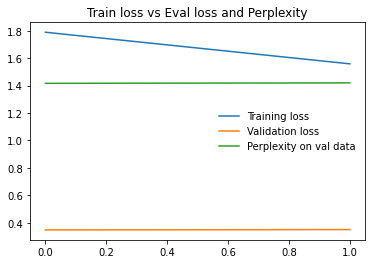

In [50]:
import matplotlib.pyplot as plt

tr_los = np.array(train_loss)
ev_los = np.array(eval_loss)
per = np.array(perplexity)

plt.plot(tr_los, label='Training loss')
plt.plot(ev_los, label='Validation loss')
plt.plot(per, label='Perplexity on val data')

plt.legend(frameon=False)
plt.title('Train loss vs Eval loss and Perplexity')
plt.show()

In [51]:
def generator(model, dataset_loader):
  
  model.eval()

  results = {"generated_summary": [], "golden_summary": []}

  with torch.no_grad():

    for idx, data_val in enumerate(dataset_loader):
      
      input_ids, source_mask, summary_ids, summary_mask = data_val 
      
      input_ids = input_ids.to(device, dtype = torch.long)
      source_mask = source_mask.to(device, dtype = torch.float)
      summary_ids = summary_ids.to(device, dtype = torch.long)

      generatation = model.generate(input_ids=input_ids,
                                    attention_mask=source_mask, 
                                    min_length=30, 
                                    max_length=300, 
                                    num_beams=1,
                                    repetition_penalty=2.5,
                                    eos_token_id = model.decoder.config.eos_token_id,               
                                    length_penalty=1.0, 
                                    early_stopping=True
                                    )

      for gen, sc in zip(generatation, summary_ids): # Taking whole document IDs and docode the summary

        gen_tokens_dec = tokenizer.decode(gen, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        sc_tokens_dec = tokenizer.decode(sc, skip_special_tokens=True, clean_up_tokenization_spaces=True)

        results["generated_summary"].append(gen_tokens_dec)
        results["golden_summary"].append(sc_tokens_dec)

  return results


#### Loading Saved Model

In [ ]:
load_weights = False

if load_weights:    

    model = .... # first initialize the model and optimizer
    optimizer = ... # optimizer then,
    PATH = ...
    
    load_pretrained_weights(model, optimizer, PATH, pretrained=load_weights)

In [61]:
!ls /root/Projects


Final_Project.ipynb	     Wheat_rust_classification.ipynb
README.md		     model.pt
T5_ftransfer_learning.ipynb  valid_processed.pkl
Untitled.ipynb		     wandb


In [22]:
#model.load_state_dict(torch.load('/root/Projectsmodel0.pt'))
#model = model.to(device)

In [90]:
ivind = valind[5000:6000]

X_trial = X_valid.iloc[ivind]

Xtest_trial = X_trial.reset_index(drop=True)

argsval = {'max_article_tokens': 700,
                'max_summary_tokens': 250
             }
    
    
val_loader  = get_dataloader(Xtest_trial, 8,valid='valid', **argsval)

In [53]:
%time results = generator(my_model, val_loader)

CPU times: user 5min 57s, sys: 20.5 s, total: 6min 17s
Wall time: 5min 42s


In [91]:
%time results = generator(my_model, val_loader) # 600, 5 bs

CPU times: user 7min 17s, sys: 17.3 s, total: 7min 34s
Wall time: 6min 52s


#### Visualizing examples

**Example 1**

In [54]:
Xtest_trial.iloc[0,:]['text']

'In the World Cup in Mexico in 1986, England came up against Argentina in the quarter finals. The game took place four years after the Falklands War. The two countries were not best pals.\n\nSix minutes into the second half, Diego Maradona punched his way into history in a way Audley Harrison never quite managed. A few minutes later he scored one of the greatest goalsof all time, but the English prefer not to dwell on that one.\n\nBut what if the first goal had been disallowed? How might things have gone down?\n\nSix minutes into the second half and Maradona cuts inside from the left and plays a diagonal pass to Jorge Valdano on the edge of the area. The pass is slightly behind Valdano and England s Steve Hodge goes to hook the ball clear. He miscues it terribly and El Diego, having continued his run into the box, jumps in the air and uses his left hand to knock the ball past Peter Shilton in goal.\n\nThe infringement is so blatant that Tunisian referee Ali Bin Nasser cannot fail to sp

In [55]:
print("Actual summary:")
results['golden_summary'][0]

Actual summary:


'In theWorld CupinMexicoin 1986, England came up againstArgentina in the quarter finals. The game took place four years after the Falklands War. The two countries were not best pals. Six minutes into the second half,Diego Maradona punched his way into history in a wayAudley Harrisonnever quite managed. A few minutes later he scored one of the'

In [56]:
print('Generated summary:')
results['generated_summary'][0]

Generated summary:


'Diego Maradona s late goal in the quarter final was disallowed, but what if his first goal had been disallowed?'

**Example 2**

In [57]:
Xtest_trial.iloc[1,:]['text']

'updated 07 30 2014 at 03 10 PM EDT\n\nIt s one of the paradoxes of globalization many of the people who produce the raw materials for products we take for granted can t afford to buy those products themselves.\n\nTake the case of cocoa farmers in the Ivory Coast, the world s leading exporter of cocoa beans. \n\n, only 3 of the money you pay for a chocolate bar makes it back to the farmers who grow the beans. The rest goes to the people further up the supply chain, the ones who transform the beans into chocolate and sell it it stores across the globe. Ivory Coast farmers make roughly 10 a day, putting a 2 chocolate bar out of reach.\n\nSo it was a heartwarming occasion when\n\n, a reporter for the Netherlands \n\n, traveled to the Ivory Coast to introduce cocoa farmers to the sweet taste they d helped bring into the world.\n\nwho had never seen the iPads he helped produce, this one appears to be legit. As N Da Alphonse, the first farmer in the clip, explained, he knew his cocoa beans w

In [58]:
print("Actual summary:")
results['golden_summary'][1]

Actual summary:


'Farmers in the Ivory Coast can t afford to buy the chocolate they help produce'

In [59]:
print('Generated summary:')
results['generated_summary'][1]

Generated summary:


'Cocoa farmers in the Ivory Coast are bringing their sweet taste to the world. Here is a video of them making chocolate bars'

**Example 3**

In [60]:
Xtest_trial.iloc[3,:]['text']

'For Isaac Owusu, a widower, the revelation has forced him to rethink nearly everything he had taken for granted about his life and his family.\n\nIt has left him struggling to accept what was once unthinkable that his deceased wife had long been unfaithful that the children he loves are not his own and that his long efforts to reunite his family in this country may have been in vain.\n\nThe State Department let his oldest son, now 23, come to the United States last fall, but said the others a 19 year old and 17 year old twins could not come because they are not biologically related to him.\n\nIsaac Owusu, who asked that only his first and middle names be published because he would like to keep his family s pain private, is still hoping the government will allow the teenagers to join him, arguing that he has been a devoted stepfather, if not a biological parent.\n\nBut in recent months, he says, he has simply unraveled.\n\n Sometime when I get in bed, I don t sleep, said Isaac Owusu, 5

In [61]:
print("Actual summary:")
results['golden_summary'][3]

Actual summary:


'Genetic tests are forcing some immigrant families to confront unexpected and sometimes unbearable truths.'

In [62]:
print('Generated summary:')
results['generated_summary'][3]

Generated summary:


'Isaac Owusu, a widower who was told his death would be the result of genetic testing. But is it possible to bring relatives close?'

**Example 4**

In [63]:
Xtest_trial.iloc[4,:]['text']

'Their personalities contrast as starkly as their styles Smith is genial and expressive, Boldin private and intense but they are bonded by their past, by adversity that shaped them then, that influences them now.\n\nFor Smith, his electrifying performance in Denver was his most complete game since Sept. 23, when he carved up the Patriots with 6 catches for 127 yards and 2 touchdowns in a 31 30 victory. On Wednesday, he explained his success by saying, I just happened to play well against them. \n\nReceiver Jacoby Jones offered a different reaction.\n\n I told him, Man, I look up to you, Jones said. I couldn t have done what you did. \n\nJust before midnight on Sept. 22, Smith s younger brother Tevin Jones, 19, crashed his motorcycle into a utility pole in their native Virginia. He died at the scene. Smith left the Ravens hotel about 2 a.m. and raced home to grieve with his family. About 12 hours later, after barely sleeping, he rejoined his teammates. Kevin Glover, the longtime N.F.L. 

In [64]:
print("Actual summary:")
results['golden_summary'][4]

Actual summary:


'Torrey Smith, who turns 24 next Saturday, cites Anquan Boldin s tutelage as a major factor in his development, but theirs is a symbiotic relationship.'

In [65]:
print('Generated summary:')
results['generated_summary'][4]

Generated summary:


'The star quarterback s career was his most complete game since Sept. 23, when he carved up the Patriot defense with 6 catches for 127 yards and 2 touchdown passes in a 31 30 victory over the Ravens on Wednesday night, but it was his most complete performance since Sept'

**Example 5**

In [66]:
Xtest_trial.iloc[5,:]['text']

'One of the most enduring stereotypes in the American workplace is that of the queen bee the executive female who, at best, doesn t help the women below her get ahead and, at worst, actively hinders them. This supposed species has been analyzed in newspaper essays, described in surveys and caricatured over and over again in Hollywood.\n\nBut a recent study casts doubt on the idea. Researchers at Columbia Business School and the University of Maryland s business school looked at what happens after a woman gets one of the five highest paying executive jobs at an SandP 1500 firm. They found that it decreased the probability of another woman also getting a top position by 51 percent though not for the reason often cited.\n\nGiven the queen bee stereotype, people have often posited that the woman at the top might be trying to hold other women back from joining her. Yet the researchers suggest that their findings instead suggest the culprit is implicit quotas, in which companies feel pressur

In [67]:
print("Actual summary:")
results['golden_summary'][5]

Actual summary:


'A recent study casts doubt on the the long held stereotype that women who get ahead don t help other women.'

In [68]:
print('Generated summary:')
results['generated_summary'][5]

Generated summary:


'A new study suggests that the queen bee is a problem. But it may actually help women get ahead and at worst actively hinder them, too'

**Example 6**

In [69]:
Xtest_trial.iloc[6,:]['text']

'Louisiana Gov. Bobby Jindal will again carry the Republican mantle opposite a primetime appearance from President Obama on Tuesday.\n\nJindal, considered a potential GOP presidential candidate, is slated to headline a major congressional fundraiser that coincidentally fell on the same night as Obama s planned news conference.\n\nJindal was widely panned for his televised response to Obama s address to Congress last month. This time, he will speak to a live audience of Republican faithful in Washington. And his speech scheduled well before Obama s news conference will likely begin before Obama s evening remarks.\n\nJindal is likely to criticize Obama s 3.6 trillion budget request, which Republicans have repeatedly said borrows too much, spends too much and taxes too much. \n\nIn his response to Obama address last month, Jindal criticized the president s 787 billion economic stimulus package as laden with unnecessary spending that had been added by a Democratic Congress. He talked of th

In [70]:
print("Actual summary:")
results['golden_summary'][6]

Actual summary:


'Louisiana Gov. BobbyJindal is slated to headline a major congressional fundraiser that coincidentally fell on the same night as President Obama s planned news conference.'

In [71]:
print('Generated summary:')
results['generated_summary'][6]

Generated summary:


'Louisiana Gov. Bobby Jindal will again carry the Republican mantle opposite a primetime appearance from President Obama on Tuesday, according to his presidential address at Congress last night'

**Example 7**

In [72]:
Xtest_trial.iloc[7,:]['text']

'It s The Lyttleton Inn in Littleton, Mass., according to BedandBreakfast.com.\n\nThe inn took first price in BedandBreakfast.com s first Breakfast Recipe Challenge with its bittersweet chocolate waffles with mint buttercream and strawberry sauce.\n\nSeems as if voters like to start the day on a sugary note That confection barely beat pumpkin pancakes with caramelized pecans, whipped cream and ginger syrup, served at the Gracehill Bed and Breakfast in Townsend, Tenn.\n\nWant to see all 16 finalists or get a copy of the competing recipes? I like the one for lobster frittata at The Mill House Inn in East Hampton, N.Y. Click here.\n\nWinners were selected by BedandBreakfast.com s Facebook fans. More than 2,500 votes were recorded.\n\nFunny that sweet beat savory, because in a survey of BandB travelers, BedandBreakfast.com found that the bacon and eggs were the top breakfast choice 47 of votes , followed by carbs pancakes, waffles, bagels , fruit yogurt, granola and other cereals.\n\nReade

In [73]:
print("Actual summary:")
results['golden_summary'][7]

Actual summary:


'Bedandbreakfast.com had a recipe contest. So which won? The chocolate waffles or pumpkin pancakes?'

In [74]:
print('Generated summary:')
results['generated_summary'][7]

Generated summary:


'It s The Lytleton Inn in Littletown, Mass., according to BedandBreakfast andmdash the inn took first pricein Bedandrsquo s first Breakfast Recipe Challenge with its bittersweet chocolate waffle'

**Example 8**

In [75]:
Xtest_trial.iloc[8,:]['text']

'An outsider might think Jami Rodman ruined the life of Suzy Favor Hamilton as a powerful madam in Las Vegas, Rodman took the former Olympian in as a call girl, leading to the explosive expose of their sex service in 2012 that put them out of sex work for good.\n\nBut Rodman tells the Daily News she and Hamilton are still good friends, so much so that Hamilton inspired Rodman s upcoming book about her hooker world history, The Las Vegas Madam The Escorts, The Clients, The Truth. \n\nHamilton encouraged me to work on the book, Rodman, 37, said. I think because a lot of it would be very cathartic. It s that whole theory of writing a diary to help understand yourself. \n\nRodman s book, which she s self publishing, comes out Dec. 11 just three months after Hamilton s own memoir, Fast Girl A Life Spent Running from Madness, which hits shelves Tuesday. Rodman calls it a coincidence.\n\nHamilton s book has been hyped as a wrenching recollection of the demons that drove the three time Olympic

In [76]:
print("Actual summary:")
results['golden_summary'][8]

Actual summary:


'Jami Rodman s book The Las Vegas Madam, out in December, tells the story of the madam who hired the former Olympian as a hooker.'

In [77]:
print('Generated summary:')
results['generated_summary'][8]

Generated summary:


'Jami Rodman s new book, Fast Girl A Spy Running from Madness, hits shelves Dec. 11. She says she and Hamilton are still good friends'

**Example 9**

In [78]:
Xtest_trial.iloc[9,:]['text']

'A Bangladeshi father nicknamed Tree Man for massive bark like warts on his hands and feet will finally have surgery to remove the growths that first began appearing 10 years ago, a hospital has said.\n\nAbul Bajandar, from the southern district of Khulna, was undergoing preparations for the surgery to cut out the growths weighing at least 5kg 11lb that have smothered his hands and feet.\n\n Initially, I thought that they re harmless, the 26 year old told AFP at the Dhaka Medical College hospital. But slowly I lost all my ability to work. There are now dozens of two to three inch roots in both my hands. And there are some small ones in my legs, said Bajandar who was forced to quit working as a bicycle puller.\n\nA team of doctors will perform the operation at DMCH, Bangladesh s largest state run hospital, which has decided to waive the costs of the treatment. Tests are under way to ensure Bajandar s warts can be removed surgically without damaging major nerves or causing any other heal

In [79]:
print("Actual summary:")
results['golden_summary'][9]

Actual summary:


'Abul Bajandar preparing for operation to remove extremely rare epidermodysplasia verruciformis warts'

In [80]:
print('Generated summary:')
results['generated_summary'][9]

Generated summary:


'A Bangladeshi father nicknamed Tree Man for massive bark like warts on his hands and feet will finally have surgery to remove the growth that first began appearing 10 years ago, a hospital has said.'

**Example 10**

In [81]:
Xtest_trial.iloc[15,:]['text']

'By now all of us have heard the ominous warnings about the unraveling of the social safety net. But what does this really mean? And what can we as private citizens who have also been both personally and professionally deeply affected by the financial crisis do to repair it?\n\nThe social safety net encompasses the array of health and human services provided by state and local authorities. As the economic crisis causes state budgets to contract, funding for these services plummets, and the net that we collectively rely on to catch us from falling into extreme poverty begins to unravel. To be sure, private donors alone cannot single handedly save vital community services, but for those of us interested in maximizing the value of our charitable dollars in a time of crisis, investments in social service agencies can offer meaningful returns.\n\nLast month, Giving USA reported the largest decline in charitable giving in the U.S. Most alarming was the data showing a nearly 16 decrease in th

In [82]:
print("Actual summary:")
results['golden_summary'][15]

Actual summary:


'Betsy Brill discusses what people can do to repair the unraveling social safety net.'

In [83]:
print('Generated summary:')
results['generated_summary'][15]

Generated summary:


'By now all of us have heard the ominous warnings aboutthe unravelingof social safety net. But what does this really mean? Andwhat can we as private citizens who'

### Performance

In [84]:
!pip3 install rouge
from rouge import Rouge

In [85]:
!pip3 install rouge-score tqdm
from rouge_score import rouge_scorer, scoring

In [86]:
from typing import Dict

def get_score(summaries) -> Dict:  
    
    src_labels = summaries['golden_summary']
    gen_summary = summaries['generated_summary']
    
    scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
    aggregator = scoring.BootstrapAggregator()
    
    for src, gent in zip(src_labels, gen_summary):
        scores = scorer.score(gent, src)
        aggregator.add_scores(scores)
        
    results = aggregator.aggregate()
    return {key: val.mid.fmeasure for key, val in results.items()}

In [87]:
get_score(results) # 700, 8 bs

{'rouge1': 0.37884463730331164,
 'rouge2': 0.22701712662455636,
 'rougeL': 0.3251312465423435}

In [92]:
get_score(results) # 600, 5 bs

{'rouge1': 0.37879043141411406,
 'rouge2': 0.22828057620565184,
 'rougeL': 0.3269038025069393}

In [88]:
rouge = Rouge()

score = rouge.get_scores(results['generated_summary'], results['golden_summary'], avg=True)
{key: val['f'] for key, val in score.items()}

{'rouge-1': 0.3436117352541544,
 'rouge-2': 0.2096320892460095,
 'rouge-l': 0.3277109454445723}

In [ ]:
{'rouge-1': 0.23891854897729273,
 'rouge-2': 0.10855931785640041,
 'rouge-l': 0.21982563644064748}

In [ ]:
{'rouge-1': 0.2934569607894014,
 'rouge-2': 0.16207342615668757,
 'rouge-l': 0.2762959592687011} #0.2